MotorwaySegment of "A2" with start Point(x=8.9287827, y=46.0685891) and end Point(x=8.928685, y=46.0680586). 	 epsg:4326
MotorwaySegment of "A2" with start Point(x=2715295.589739048, y=1102990.6704969718) and end Point(x=2715289.151463621, y=1102931.5637740814). 	 epsg:2056


/Users/cynthia/Document_local/geo877/data_Preprocessing.py:194: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  mway_ch_geometries_exp = mway_ch_geometries.explode()
/Users/cynthia/opt/anaconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


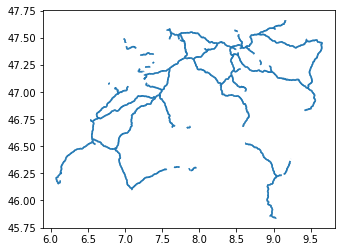

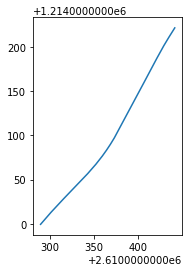

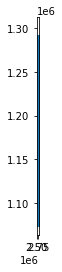

In [1]:
# SETUP
# =====
%run ./data_Preprocessing.py
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [2]:
# Aim to add cell_index column
# =====
class CellSegment(Segment):
    def __init__(self, start, end):
        super().__init__(start, end)
        self.name = name
        self.index1 = 0
        self.index2 = 0
    
    def __repr__(self):
        return f'MotorwaySegment of "{self.name}" with start {self.start} and end {self.end}, start cell in {self.index1} and end cell in {self.index2}.'
    

In [3]:
# Aim to package all the related variables and functions to one class
# =====
class CellLength():
    def __init__(self, data, box, res):
        
        self.data = data
        # Number of grid rows and colums
        self.res = res #res = resolution
        self.w = box.ur.x - box.ll.x
        self.h = box.ur.y - box.ll.y
        self.nCols = int(self.w/ self.res)+1
        self.nRows = int(self.h/ self.res)+1
        
        ur = Point(box.ll.x + (self.nCols * self.res), box.ll.y + (self.nRows * self.res))
        ll = box.ll
        self.bBox = Bbox([ll, ur])
        
        # Cell with index to store the length
        self.maxIndex = (self.nCols * self.nRows) -1        
        i = 0
        self.cellLength = []
        while i <= self.maxIndex:
            self.cellLength.append(0)
            i += 1  
            
    def addIndex(self):
        for segment in self.data:
            segment.index1 = self.pointIndex(segment.start)  # add index of start point
            segment.index2 = self.pointIndex(segment.end)  # add index of end point   
    
    def pointIndex(self, p): # Define the which cell the point is in
        j = int((p.y - self.bBox.ll.y)/ self.res)
        i = int((p.x - self.bBox.ll.x)/ self.res)
        return (j * self.nCols) + i    

    def addLength(self):
        self.addIndex()
        
        #just for test
        self.length=0
        self.seg_ab = []
        # ===
        
        for seg in self.data:
            if seg.index1 == seg.index2: # if in the same cell
                index = seg.index1
                self.cellLength[index] = self.cellLength[index] + self.segLength(seg.start,seg.end) # start_p, end_p
                self.length = self.length + self.segLength(seg.start,seg.end)
            else:
                
                #just for test
                #self.length = self.length + seg.length
                seg_lengtht = 0
                # ===
                
                point1 = seg.start
                point2 = seg.end
                index1 = seg.index1
                index2 = seg.index2
                
                j1 = int((point1.y - self.bBox.ll.y)/ self.res)
                i1 = int((point1.x - self.bBox.ll.x)/ self.res)
                j2 = int((point2.y - self.bBox.ll.y)/ self.res)
                i2 = int((point2.x - self.bBox.ll.x)/ self.res)
                
                min_i = min(i1,i2)
                max_i = max(i1,i2)
                min_j = min(j1,j2)
                max_j = max(j1,j2)
                
                k = (point2.y - point1.y)/(point2.x - point1.x)
                b =  point1.y - (k * point1.x)
                
                points = []
                points.append(point1)
                points.append(point2)
                
                while min_j < max_j: 
                    intersect_y = (min_j + 1)*self.res + self.bBox.ll.y 
                    intersect_x = (intersect_y - b)/k
                    point_new = Point(intersect_x,intersect_y)
                    points.append(point_new)
                    min_j = min_j + 1
                    
                while min_i < max_i: 
                    intersect_x = (min_i + 1)*self.res + self.bBox.ll.x
                    intersect_y = k*intersect_x + b
                    point_new = Point(intersect_x,intersect_y)
                    points.append(point_new)
                    min_i = min_i + 1
                
                points_r = []
                points_count = len(points)
                for n in range(points_count):
                    m = 0
                    p = 0
                    for i in range(len(points)):
                        if points[i].x > m:
                            m = points[i].x
                            p = i # store the point index
                    points_r.append(points[p])
                    points.pop(p) #delete list element 
                
                # Just for test
                # for i in points_r:
                #    print(f"{i.x},{i.y}")
                # ===
            
                #calculate length
                for i in range(len(points_r)-1):
                    start = points_r[i]
                    end = points_r[i+1]
                    seg_cellindex = self.pointIndex(points_r[i+1])
                    self.cellLength[seg_cellindex] = self.cellLength[seg_cellindex] + self.segLength(start,end)
                    seg_lengtht = seg_lengtht + self.segLength(start,end)
                    self.length = self.length + self.segLength(start,end)
                    #print(f"start{start},end{end},length{self.segLength(start,end)}")
                if seg_lengtht != seg.length: 
                    self.seg_ab.append(seg)
    
    def segLength(self,p1,p2):  # calculate segment length
        return p1.distEuclidean(p2) 
    

In [19]:
# The rest is in "main()"

# bBox and res (bBox is fixed, user can change res value)
xs = 2250000
xf = 3000000
ys = 1075000
yf = 1300000
box = Bbox([Point(xs, ys), Point(xf, yf)])
res = 100000 # can change

In [20]:
# osm dataset: 
cellSegments = []
for segment in motorway_segments_transformed:
    cellSegment = CellSegment(segment.start,segment.end)
    cellSegments.append(cellSegment)
cellLength = CellLength(cellSegments, box, res)
cellLength.addIndex()
cellLength.addLength()
# osm result
cellLength.cellLength

[0,
 0,
 230019.2601430874,
 326390.98708058987,
 271134.60475392593,
 0,
 0,
 0,
 0,
 0,
 93116.43646494958,
 940855.0752752543,
 970128.3465211364,
 224946.12792981716,
 0,
 0,
 0,
 0,
 0,
 0,
 15592.038506834877,
 0,
 0,
 0]

In [21]:
# Astra dataset:
cellSegments_ch = []
for segment in motorway_ch_segments:
    cellSegment_ch = CellSegment(segment.start,segment.end)
    cellSegments_ch.append(cellSegment_ch)
    
cellLength_ch = CellLength(cellSegments_ch, box, res)
cellLength_ch.addIndex()
cellLength_ch.addLength()
# Astra result
cellLength_ch.cellLength

[0,
 0,
 326082.47028001066,
 644153.4538565582,
 540949.4321693174,
 84117.54621805742,
 0,
 0,
 0,
 0,
 151001.54326338248,
 1512843.679283428,
 1528333.830693827,
 371171.98726333666,
 0,
 0,
 0,
 0,
 0,
 0,
 75647.26120308418,
 0,
 0,
 0]

In [22]:
# Comparison
result1 = cellLength.cellLength
result2 = cellLength_ch.cellLength
result = []
for i in range(len(result1)):
    result.append(0)
    if result1[i] != 0 and result2[i] != 0:
        result[i] = (result1[i] / result2[i])*100
    elif result1[i] == 0  and result2[i] == 0:
        result[i] = -1
    elif result1[i] == 0  and result2[i] != 0:
        result[i] = 0
    else: 
        result[i] = 100
        
a = np.zeros(shape=(cellLength.nCols,cellLength.nRows))
for i in range(cellLength.nCols):
    for j in range(cellLength.nRows):
        b_i = (j * cellLength.nCols) + i  
        a[i][j] = result[b_i]
        
print(a)

[[-1.         -1.         -1.        ]
 [-1.         -1.         -1.        ]
 [70.54021026 61.66588397 -1.        ]
 [50.66975658 62.19116279 -1.        ]
 [50.12198713 63.47620703 20.61150431]
 [ 0.         60.60428471 -1.        ]
 [-1.         -1.         -1.        ]
 [-1.         -1.         -1.        ]]


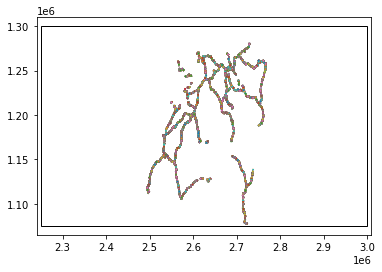

In [12]:
# This part is not needful, just to show where bBox is and osm data
figure, axes = plt.subplots()
rect = plt.Rectangle((cellLength.bBox.ll.x,cellLength.bBox.ll.y), cellLength.w, cellLength.h, fill= False)

for seg in cellSegments:
    x1 = [seg.start.x, seg.end.x]
    y1 = [seg.start.y, seg.end.y]
    plt.plot(x1, y1)
    
plt.xlim([xs-10000, xf+10000])
plt.ylim([ys-10000, yf+10000])
axes.add_artist(rect)
plt.show()

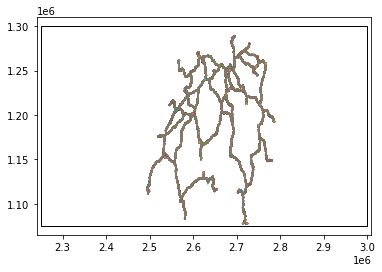

In [11]:
# This part is not needful, just to show where bBox is and Astra data
figure, axes = plt.subplots()
rect = plt.Rectangle((cellLength.bBox.ll.x,cellLength.bBox.ll.y), cellLength.w, cellLength.h, fill= False)
for seg in cellSegments_ch:
    x1 = [seg.start.x, seg.end.x]
    y1 = [seg.start.y, seg.end.y]
    plt.plot(x1, y1)
    
plt.xlim([xs-10000, xf+10000])
plt.ylim([ys-10000, yf+10000])
axes.add_artist(rect)
plt.show()